# TrIPP tutorial - Lysozyme test case

In the following example we will use TrIPP to monitor and analyse the p*K*<sub>a</sub> of ionisable residues during Molecular Dynamics (MD) simulations of the hen egg-white lysozyme (HEWL; PDB ID: 1AKI). The input files to run this tutorial (provided in the *data* folder) are:

* **1AKI_minstr.pdb**: energy minimised structure in PDB format (1960 atoms)
* **1AKI_md1_300ns.xtc** and **1AKI_md2_300ns.xtc**: trajectory files of two 308.5-ns replicas in xtc format (frames are sampled every 100 ps, water molecules and counterions have been removed, the system is composed of a single-chain protein with no ligand)
* **1AKI_md1_pc1.csv**: projection of 1AKI_md1_300ns.xtc onto its first principal component (PC1)  

The protonation state of ionisable residues during the MD simulations was determined using PROPKA (version 3.4.0) on the initial structure (pH = 7.0).

**Running time:** running all the parts of this tutorial on a Macbook Pro (M2 Pro) using 12 cores requires about 6 minutes.

**Important note on PROPKA** 

PROPKA has some requirements on the format of the input PDB file, in particular:

1. PROPKA only recognizes specific residue names (for the standard 20 amino acids).
2. The names of the two C-terminal oxygen atoms should be O and OXT.
3. The record type of non-protein atoms (e.g., a ligand) should be 'HETATM'.

TrIPP has a hard-coded dictionary (tripp.\_correction_dictionary_.py) that converts a list of standard residue names recognised by MDanalysis (https://userguide.mdanalysis.org/stable/standard_selections.html) to names compatible with PROPKA. A dictionary is also used to convert C-terminal oxygen atom names used in the GROMOS, AMBER or CHARMM force fields to the PROPKA format. 

#### *** to be changed Very unclear:
Molecules that are not recognized by MDAnalysis (not protein) could still be a residue or non protein molecules. Thus, we have also implemented a check for this so that user will be warned to modify it accordingly.

# 0. Libraries and user-defined variables 

Let's first import the required libraries...

In [49]:
from tripp import Trajectory
from tripp.analysis import calculate_difference_to_model
from tripp.analysis import PCProjectionScreening  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from itertools import combinations
from tripp._model_pka_values_ import model_pka_values
from tripp import Visualization  # PyMOL installation required, user needs to specify the path to the PyMOL executable (see Part 2)
from tripp import Clustering 

... and define some variables. To run this tutorial on your own trajectories, you will need to change the value of some user-defined variables. **Important:** while in principle MDAnalysis supports different trajectory and topology formats, we have tested our tool only on xtc files generated with GROMACS. 

In [2]:
# Start of user-defined variables -------------------------

topology = '1AKI_minstr.pdb'  # name of the reference PDB file used to define the topology of the system
input_dir = 'data'            # name of the folder containing the input files
traj_prefix_list = ['1AKI_md1_300ns', '1AKI_md2_300ns'] # list of input trajectories (without the extension)
traj_format = 'xtc'           # extension of trajectory input files (only xtc files have been tested)
output_dir = 'output'         # name of the folder where all output files and folders will be saved

# End of user-defined variables -------------------------

ntraj = len(traj_prefix_list)
topology_file = input_dir + '/' + topology
trajectory_files = [input_dir + '/' + x + '.' + traj_format for x in traj_prefix_list]

pka_files = [output_dir + '/' + x + '/' + x + '_pka.csv' for x in traj_prefix_list]
buriedness_files = [output_dir + '/' + x + '/' + x + '_buriedness.csv' for x in traj_prefix_list]
trajectory_dict = {x: input_dir + '/' + x + '.' + traj_format for x in traj_prefix_list}

output_directories = [output_dir + '/' + x for x in traj_prefix_list]
output_prefix = traj_prefix_list

In the next sections, you will learn how to:
1. Predict p*K*<sub>a</sub> of ionisable residues and analyse the distribution of the p*K*<sub>a</sub> values for the entire trajectory.
2. Colour the ionisable residues by their p*K*<sub>a</sub> in a 3D representation of the protein. A PyMOL installation is required.
3. Cluster the trajectory frames on the basis of the p*K*<sub>a</sub> values of selected residues and retrieve cluster representatives.
4. Perform pseudo-mutations of selected residues to assess their contribution to the p*K*<sub>a</sub> of nearby ionisable residues.
5. Detect correlations between pKa changes and collective motions.

# 1. Trajectory p*K*<sub>a</sub> prediction

`Trajectory` is the main class provided by TrIPP and it can be used to automatically run PROPKA predictions on all the frames of the input trajectory. The calculation is sped up by slicing the trajectory into different parts, which are processed in parallel. The p*K*<sub>a</sub> and (only if requested) buriedness values of each ionizable residue are saved into individual CSV files.

In the cell below, the `Trajectory` class is used to track the predicted p*K*<sub>a</sub> values of HEWL ionisable residues in two MD trajectories. **The running time on a Macbook Pro (M2 Pro) using 12 cores is ~ 1 minute**. A successful run of this cell will produce the following files:

* **output/1AKI_md1_300ns/1AKI_md1_300ns.log**: log file with a summary of the settings, trajectory splits, run time and some statstics (Mean,Median,Standard Deviation of p*K*</sub>a</sub> values for each ionisable residue)
* **output/1AKI_md1_300ns/1AKI_md1_300ns_pka.csv**: csv file with the time (ps) in the first column + pka values for the ionisable residues calculated during the trajectory (1 column for each residue) 
* **output/1AKI_md1_300ns/1AKI_md1_300ns_buriedness.csv**: csv file with the time (ps) in the first column + pka values for the ionisable residues calculated during the trajectory (1 column for each residue)

plus equivalent folders and files for the second trajectory (1AKI_md2_300ns.xtc).

**Note on 'Missing atoms' warning from PROPKA**: occasionally PROPKA might give a warning about "Missing atoms or failed protonation for XXX -- please check the structure", where XXX is an acidic or basic group of a residue as recognised by PROPKA. This is related to the use of PROPKA of pre-defined interaction atoms for these groups: https://propka.readthedocs.io/en/latest/_modules/propka/group.html. 

In [3]:
for idx in range(ntraj):
    print(f'Processing {trajectory_files[idx]}')
    TrIPP_Traj = Trajectory(topology_file = topology_file,
                            trajectory_file = trajectory_files[idx],
                            output_directory = output_directories[idx],
                            output_prefix = output_prefix[idx],
                            hetatm_resid = None,   # list (?) of PDB resid values for non-protein molecules 
                                                   # that we want PROPKA to take into account in the pKa calculation.
                                                   # Their record type will be set to 'HETATM'.
                            custom_terminal_oxygens = None,  # names of terminal oxygen atoms when different from ['O', 'OXT'], 
                                                             # provided as a list, e.g.: ['OC1', 'OC2']
                            custom_resname_correction = None,   # dictionary of custom protein residue names not included in
                                                                # the hard-coded TrIPP dictionary (tripp._correction_dictionary_.py). 
                                                                # Can be given as e.g. {'XXX':'ASP'}, where 'XXX' is the residue
                                                                # name in the PDB file and 'ASP' is the corresponding
                                                                # PROPKA name.
                            cpu_core_number = -1)   # number of CPU cores. Set to -1 to use all available cores.
    
    TrIPP_Traj.run(extract_buriedness_data = True,   # Set to True to save also the buriedness values, 
                                                     # otherwise only pKa values are saved. 
                   chain = 'A',   # PROPKA will calculate the pKa values for residues in this chain. 
                                  # Other chains will be taken into account in the calculation 
                                  # (so they can affect the pKa values of ionisable residues in the selected chain).    
                                  # If the reference PDB file does not have chain IDs, the ID specified here will be added
                                  # to all the atoms in the system.
                   mutation = None,   # Set to None to run PROPKA on the original residues (no pseudo-mutations).
                                      # See Section 4 to run pseudo-mutations.
                   disulphide_bond_detection = True,   # If set to True, pka and buriedness values for cysteines 
                                                       # forming a disulphide bond will not be saved in the CSV files.
                   optargs = [])  # optargs for PROPKA.run.single()
    print('---------------------------------------------------------------------------------')

Processing data/1AKI_md1_300ns.xtc
---------------------------------------------------------------------------------
Processing data/1AKI_md2_300ns.xtc


Missing atoms or failed protonation for ASN  27 A (AMD) -- please check the structure
Group (AMD) for   415-  CG    27-ASN (A) [  34.720   45.140   38.560] C
Expected 3 interaction atoms for acids, found:
               417- ND2    27-ASN (A) [  35.230   44.950   39.650] N
                 0- HD2    27-ASN (A) [  35.877   44.950   40.426] H
Expected 1 interaction atoms for bases, found:
               416- OD1    27-ASN (A) [  33.630   44.640   38.510] O
Missing atoms or failed protonation for ASN 106 A (AMD) -- please check the structure
Group (AMD) for  1572-  CG   106-ASN (A) [  25.120   50.670   38.470] C
Expected 3 interaction atoms for acids, found:
              1574- ND2   106-ASN (A) [  24.060   51.190   38.060] N
                 0- HD2   106-ASN (A) [  23.373   51.848   37.721] H
Expected 1 interaction atoms for bases, found:
              1573- OD1   106-ASN (A) [  24.970   49.530   38.690] O


---------------------------------------------------------------------------------


The distribution of the p*K*<sub>a</sub> values for each ionisable residue can be visualized by running the following cell. Heatmaps of the distributions are shown with a colour gradient (blue), while a dotted red line indicates the model p*K*<sub>a</sub> value for each residue type (*** to be changed: add link to the list of PROPKA model values). Note that N+ and C- correspond to the amino and carboxyl groups at the N- and C-terminus, respectively.

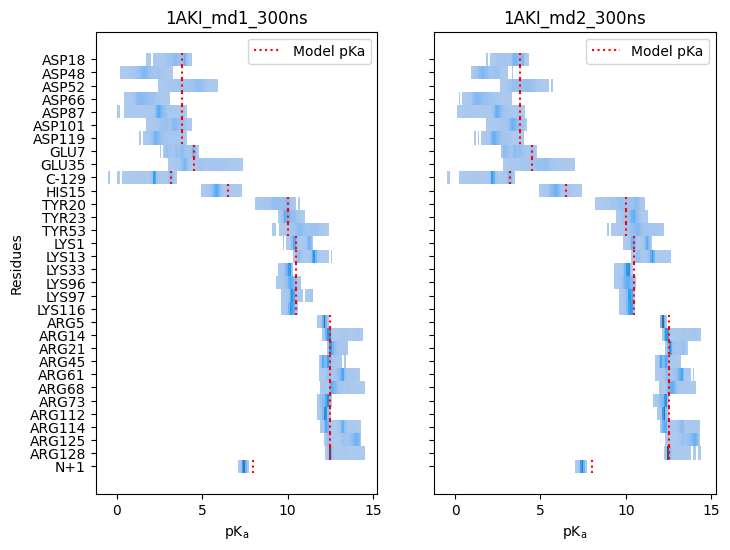

In [57]:
fig, ax = plt.subplots(1, ntraj, figsize = (4 * ntraj, 6), sharex = True, sharey = True) 

#Plot histogram showing the pKa values
for idx in range(ntraj):
    df_md = pd.read_csv(f'{output_directories[idx]}/{output_prefix[idx]}_pka.csv') 
    df_melt = df_md.melt(id_vars = 'Time [ps]', var_name = 'Residues', value_name = 'pKa value') 
    sns.histplot(data=df_melt, x = 'pKa value', y = 'Residues', ax = ax[idx], binwidth = 0.1)
    ax[idx].set(xlabel = r'pK$_{\rm a}$')
    ax[idx].set_title(f"{trajectory_files[idx].split('/')[-1].split('.')[0]}")
    #Adding model pKa value to each row
    for ytick, residue in enumerate([i[:3] for i in df_melt['Residues'].unique()]):
        if 'N+' in residue:
            ax[idx].vlines(model_pka_values['NTR'], ytick-0.5, ytick+0.5, colors = 'red', linestyles = 'dotted')
        elif 'C-' in residue:
            ax[idx].vlines(model_pka_values['CTR'], ytick-0.5, ytick+0.5, colors = 'red', linestyles = 'dotted')
        else:
            ax[idx].vlines(model_pka_values[residue], ytick-0.5, ytick+0.5, colors = 'red', linestyles = 'dotted')
    ax[idx].legend(['Model pKa'])
plt.show()

The acidic residues ASP52 and GLU35 are of particular interest since they show an upshift of their p*K*<sub>a</sub> values towards physiological pH. An increase of their p*K*<sub>a</sub> due to the changes in the local environement would change their protonation state.

TrIPP can also calculate the p*K*<sub>a</sub> deviation from the PROPKA model value for each ionisable residue and save it to a CSV file using the `calculate_difference_to_model` function. Running the cell below creates the following files:

* **output/1AKI_md1_300ns/1AKI_md1_300ns_difference_to_model.csv**: csv file with the time (ps) in the first column + pka deviation from model values for the ionisable residues calculated during the 1AKI_md1_300ns.xtc trajectory (1 column for each residue)

plus an equivalent file for the second trajectory (1AKI_md2_300ns.xtc).

In [6]:
for idx in range(ntraj):
    calculate_difference_to_model(output_directory = output_directories[idx],
                                  output_prefix = output_prefix[idx])

The distributions can be visualised as above by running the following cell:

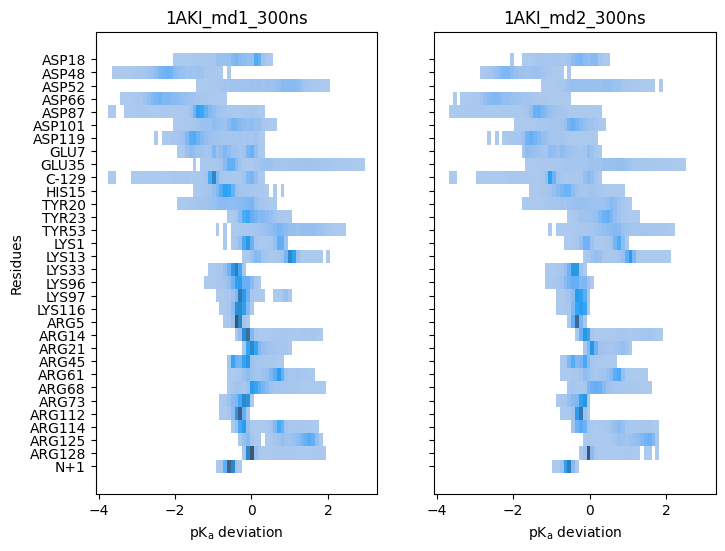

In [58]:
fig, ax = plt.subplots(1, ntraj, figsize = (4 * ntraj, 6), sharex = True, sharey = True) 

#Plot histogram showing the deviation from the model pKa values 
for idx in range(ntraj):
    df_md = pd.read_csv(f'{output_directories[idx]}/{output_prefix[idx]}_difference_to_model.csv') 
    df_melt = df_md.melt(id_vars = 'Time [ps]', var_name = 'Residues', value_name = 'pKa value deviation') 
    sns.histplot(data = df_melt, x = 'pKa value deviation', y = 'Residues', ax = ax[idx], binwidth = 0.1)
    ax[idx].set(xlabel = r'pK$_{\rm a}$ deviation')
    ax[idx].set_title(f"{trajectory_files[idx].split('/')[-1].split('.')[0]}")
plt.show()

# 2. Visualizing with PyMOL

The `Visualization` class in TrIPP allows p*K*<sub>a</sub> values to be colour mapped onto a structure provided by the user. Using this class requires specifying the path to a local PyMOL exectuable in the user-defined variables section below.

There are different options for the p*K*<sub>a</sub> values to be mapped, which can be specified with the `coloring_method` argument of `gen_pse()`:

* **'mean'**: the mean p*K*<sub>a</sub> value is mapped on each ionisable residue. Mean values are calculated over all the p*K*<sub>a</sub> files specified through the `pka_file` argument of `Visualisation`.

* **'difference_to_model_value'**: the difference between the mean and the model p*K*<sub>a</sub> value is mapped on each ionisable residue. Mean values are calculated over all the p*K*<sub>a</sub> files specified through the `pka_file` argument of `Visualisation`.

* **'correlation'**: the coupling between p*K*<sub>a</sub> and collective motions in the protein is mapped on each ionisable residue. This option requires providing an additional file (see Part 5). 

* **an integer or float**: if the timestep of a specific frame is given, the p*K*<sub>a</sub> value calculated for that frame is mapped on each ionisable residue.

Running the cell below generates the following files:

* **output/All_md_pka_mean.pse**: PyMOL session for the mean p*K*<sub>a</sub> mapping
* **output/All_md_pka_mean.pdb**: reference PDB file with mean p*K*<sub>a</sub> values in the B-factor field
* **output/All_md_pka_difference_to_model_value.pse**: PyMOL session for the difference between mean and model p*K*<sub>a</sub> mapping
* **output/All_md_pka_difference_to_model_value.pdb** reference PDB file with the difference between mean and model p*K*<sub>a</sub> values in the B-factor field

In [8]:
# Start of user-defined variables -------------------------

pymol_path = '/opt/homebrew/bin/pymol' # path to PyMOL executable
pymol_output_prefix = '1AKI_md_all_300ns_pka' # prefix of output file names

# End of user-defined variables -------------------------

TrIPP_Vis = Visualization(topology_file = topology_file, 
                          pka_file = pka_files) # Can be str or list of str, with the path to the pKa file(s)

TrIPP_Vis.gen_pse(pymol_path = pymol_path,
                  output_directory = output_dir,
                  output_prefix = pymol_output_prefix,
                  chain = 'A',
                  coloring_method = 'mean',  # generates PyMOL session with the mean pKa 
                  lower_limit = 0,   # Minimum of the colour scale
                  upper_limit = 14,  # Maximum of the colour scale
                  color_palette = 'red_white_blue')  # see https://pymolwiki.org/index.php/Spectrum for available palettes

TrIPP_Vis = Visualization(topology_file = topology_file, 
                          pka_file = pka_files) # Can be str or list of str, with the path to the pKa file(s)

TrIPP_Vis.gen_pse(pymol_path = pymol_path,
                  output_directory = output_dir,
                  output_prefix = pymol_output_prefix,
                  chain = 'A',
                  coloring_method = 'difference_to_model_value',  # generates PyMOL session with the difference between the mean and the model pKa 
                  lower_limit = -3,  # Minimum of the colour scale
                  upper_limit = 2,   # Maximum of the colour scale
                  color_palette = 'red_white_blue')  # see https://pymolwiki.org/index.php/Spectrum for available palettes

 PyMOL(TM) Molecular Graphics System, Version 3.0.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 PyMOL(TM) Molecular Graphics System, Version 3.0.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMO

Below you can see a snapshot of the mapping of mean p*K*<sub>a</sub> values (left) and of the difference between mean and model p*K*<sub>a</sub> values (right) for HEWL:

 
 
 <img src="data/Mean_pka.png" width="400"/>      <img src="data/Difference_to_model_pka.png" width="400"/>

            Mean pKa values                              Difference between mean pKa and model values      

# 3. Clustering with p*K*<sub>a</sub> values

It is useful to have a method to extract structures that are representative of the different environments around ionisable residues observed during the trajectory. 

The `Clustering` class in TrIPP can be used to cluster the frames using one of the following methods:

* **K-medoids** (implemented as `kmedoid` method of the `Clustering` class).
* A **greedy** method as described in Micheletti et al. PROTEINS: Structure, Function, and Genetics 40:662– 674 (2000)(implemented as `greedy`).
* **DBSCAN** (implemented as `dbscan`).

The features used to describe the frames in the clustering include:

* The p*K*<sub>a</sub> values of the residues of interest.
* (Optional) All the possible pairs of distances between charge centers in those residues 
* (Optional) The buriedness values of the residues of interest.

The frame features are preprocessed (Z-score normalisation) before clustering. It is also possible to run a PCA on the features before the clustering is performed. 

See the main text of the TrIPP manuscript for more details on the clustering implementation.

In [53]:
# Start of user-defined variables -------------------------

resid_clust_list = [35, 52] # list of residues to be used in the clustering (residue ID in the refernce PDB file)
resname_clust_list = ['GLU', 'ASP'] # list of residue names for each residue in resid_clust_list
clustering_output_prefix = '1AKI_md_all_300ns' # prefix of output files from the clustering analysis

# End of user-defined variables -------------------------

The code in the cell below clusters frames from all the input trajectories using K-medoids and the p*K*<sub>a</sub> values of selected residues as features. The `automatic` argument of `kmedoids` is set to True, so an automatic searching of the optimal hyperparameter values for that method (number of output clusters) is carried out.   

Running the cell produces the following files:

* **1AKI_md_all_300ns_KMedoids.log**: a log file containing the clustering details.
* **1AKI_md_all_300ns_KMedoids_C0.pdb** and **1AKI_md_all_300ns_KMedoids_C1.pdb**: PDB files of the representative structures of the two clusters found in the optimal clustering run (number of output clusters = 2).
* **1AKI_md_all_300ns_KMedoids_cluster.csv**: a CSV file containing the cluster label for each frame (optimal clustering), together with the p*K*<sub>a</sub> values of the selected residues.

In [10]:
TrIPP_Clust = Clustering(topology_file = topology_file, 
                         trajectory_file = trajectory_dict,  # Dictionary where the key is the name of the trajectory, and the value is the path to that trajectory
                         pka_file = pka_files,  # List of paths to pKa files
                         buriedness_file = buriedness_files,
                         residues = resid_clust_list,  # List of residues of interest (PDB resid)
                         output_directory = output_dir,
                         output_prefix = clustering_output_prefix, 
                         include_distances = False,  # If set to true, the feature matrix will include the euclidean distance between all the possible pairs of charge centres in the selected group of residues
                         include_buriedness = False,  # If set to true, the feature matrix will include the buriedness of the selected residues
                         dimensionality_reduction = False)  # If set to true, a principal component analysis is performed on the feature matrix before clustering. Principal components accounting for up to 90% of the total variance are retained.

TrIPP_Clust.kmedoids(automatic = True,  # automatic searching for the optimal hyperparameters of kmedoids (evaluated by Silhouette score).
                     max_clusters = 20)  # the maximum number of clusters for automatic searching.

Clustering with 2 clusters produces an average silhouette score of 0.4647.
Clustering with 3 clusters produces an average silhouette score of 0.3871.
Clustering with 4 clusters produces an average silhouette score of 0.4348.
Clustering with 5 clusters produces an average silhouette score of 0.4183.
Clustering with 6 clusters produces an average silhouette score of 0.4067.
Clustering with 7 clusters produces an average silhouette score of 0.394.
Clustering with 8 clusters produces an average silhouette score of 0.3941.
Clustering with 9 clusters produces an average silhouette score of 0.3478.
Clustering with 10 clusters produces an average silhouette score of 0.3676.
Clustering with 11 clusters produces an average silhouette score of 0.3446.
Clustering with 12 clusters produces an average silhouette score of 0.3397.
Clustering with 13 clusters produces an average silhouette score of 0.3226.
Clustering with 14 clusters produces an average silhouette score of 0.343.
Clustering with 15 clu

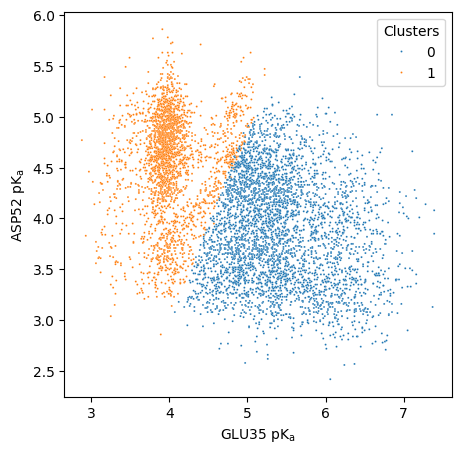

In [56]:
pairs = list(combinations(range(len(resid_clust_list)), 2))
npairs = len(pairs)

fig, ax = plt.subplots(1, npairs, figsize = (npairs * 5, 5))
ax = np.atleast_1d(ax)

for i, idx in enumerate(pairs):
    xlabel = resname_clust_list[idx[0]] + str(resid_clust_list[idx[0]])
    ylabel = resname_clust_list[idx[1]] + str(resid_clust_list[idx[1]])
    df_cluster = pd.read_csv(f'{output_dir}/{clustering_output_prefix}_KMedoids_cluster.csv') 
    sns.scatterplot(data = df_cluster, x = xlabel, y = ylabel, s = 2, hue = 'Clusters', palette = 'tab10', ax = ax[i])
    ax[i].set(xlabel = xlabel + r' pK$_{\rm a}$')
    ax[i].set(ylabel = ylabel + r' pK$_{\rm a}$')
plt.show()

We can inspect the difference between the two cluster representatives (centroids).

In cluster 0, ASN44 hydrogen bond with ASP52, which lowers the p*K*<sub>a</sub> of the aspartate. GLU35 is not interacting with ARG114 which increases its p*K*<sub>a</sub> value. 

In cluster 1, ASN44 flips away from ASP52, which interacts with the backbone of GLU35. This in turn increases the p*K*<sub>a</sub> of the aspartate. In contrast, GLU35 hydrogen bond with ARG114, which decreases the p*K*<sub>a</sub> of the glutamate. 

One could try to include distance/buriedness, or even perform dimenstionality reduction on the clustering matrix prior clustering by setting the hyperparameters to `True`.

[<img src="data/Kmedoids_C0.png" width="700"/>](data/Kmedoids_C0.png)


[<img src="data/Kmedoids_C1.png" width="700"/>](data/Kmedoids_C1.png)

# 4. _Pseudomutations_ in TrIPP 

TrIPP offers a built-in way to understand the contribution of interactions to the p*K*<sub>a</sub> of a residue. The way TrIPP does this is by running the p*K*<sub>a</sub> iterator of the `Trajectory` class and setting the `mutation` argument to the selected residues (ionisable residue near the residue of interest). This leads to TrIPP running the p*K*<sub>a</sub> calculations on the trajectory, however, with the selected residue being mutated to alanine. This does not affect the conformation of the trajectory in any way since no new MD simulations are run. By artificially removing the side chain functional group, one can determine the contribution of the selected residues to the p*K*<sub>a</sub> of another interacting residue throughout the original simulation.

In the following example, we will run a total of four _pseudomutations_ to check the contribution of: 
- ARG114 to GLU35
- ASN44, ASN46, and ASN59 to ASP52

In [ ]:
# Start of user-defined variables -------------------------
### *** to be changed: 4 mutations should be run (uncomment below and remove extra lines)
#mutations = [44, 46, 59, 114] # what are these, the resid values in the PDB or the residue indices?
#mutation_labels = ['ASN44ALA', 'ASN46ALA', 'ASN59ALA', 'ARG114ALA']
mutations = [44] # what are these, the resid values in the PDB or the residue indices?
mutation_labels = ['ASN44ALA']
residue_labels = ['ASP52', 'GLU35']

# End of user-defined variables -------------------------

mutation_output_directories = [ [output_dir + '/' + x + '_' + y for y in mutation_labels] for x in traj_prefix_list ]
mutation_output_prefix = [ [ x + '_' + y for y in mutation_labels] for x in traj_prefix_list ]

Running the following cell on a Macbook Pro (M2 Pro) requires about 5 minutes.

In [ ]:
# Cell 4.1
for idx in range(len(trajectory_files)):
    for mtype_idx, mutation in enumerate(mutations): 
        print(f'Processing pseudomutation resid {mutation} in {trajectory_files[idx]}.')
        
        TrIPP_Traj = Trajectory(trajectory_file=trajectory_files[idx], 
                                topology_file=topology_file,
                                output_directory = mutation_output_directories[idx][mtype_idx],
                                output_prefix = mutation_output_prefix[idx][mtype_idx],
                                cpu_core_number=-1) 
        
        TrIPP_Traj.run(extract_buriedness_data=False,
                        chain='A',
                        mutation=mutation,  # This can be a single or double mutation. In the case of double mutation, a list of int can be provided.
                        disulphide_bond_detection=True,
                        optargs=[])
        print('---------------------------------------------------------------------------------')

We can now plot a barplot to investigate the distribution of the p*K*<sub>a</sub> values of ASP52 and GLU35 with different _pseudomutations_ performed earlier to determine their contributions. 

In [ ]:
combined_df = []
for idx in range(len(trajectory_files)):
    pka_file = pka_files[idx]
    df = pd.read_csv(pka_file)
    df = df[['Time [ps]'] + residue_labels]
    df['Run'] = f"{trajectory_files[idx].split('/')[-1].split('.')[0]}"
    df['System'] = 'Wild Type'
    combined_df.append(df)
    for mtype_idx, name in enumerate(mutation_labels):
        mutation_pka_file = mutation_output_directories[idx][mtype_idx] + '/' + mutation_output_prefix[idx][mtype_idx] + '_pka.csv'
        df = pd.read_csv(mutation_pka_file)
        df = df[['Time [ps]'] + residue_labels]
        df['Run'] = f"{trajectory_files[idx].split('/')[-1].split('.')[0]}"
        df['System'] = mutation_name
        combined_df.append(df)
combined_df = pd.concat(combined_df)

fig, ax = plt.subplots(1,len(residue_labels), figsize=(13,5)) 
for index, residue in enumerate(residue_labels): 
    sns.boxplot(data=combined_df, x='System', y=residue, hue='Run', ax=ax[index]) 
    sns.move_legend(ax[index], "center right", bbox_to_anchor=(1.4,0.5))
    ax[index].set_ylabel(f'pKa {residue}')
ax[0].legend([],[], frameon=False)
plt.show()

From the boxplot above, we can learn that _pseudomutation_ performed on ASN44, ASN46, and ASN59 changes the p*K*<sub>a</sub> distribution of ASP52. This makes sense because all ASN form hydrogen bond with ASP52 in the original trajectory. Note that ASN44 has a slightly different trend than the other two ASN when mutated. This is because ASN44 flipped away from ASP52 in some time during the trajectory which forms no interaction with ASP52. In contrast, ARG114 is not interacting with ASP52 but with GLU35 occassionally. Hence, we can see the change in p*K*<sub>a</sub> distribution of GLU35 when mutating ARG114 only.

# 5. Automated screening of custom PC projections

To understand the dynamics of the system, one can perform dimensionality reduction, such as principal component (PC) analysis, on the trajectory. The motion of the protein described by principal components could be related to the p*K*<sub>a</sub> values. To facilitate this analysis, we have implemented a function to automatcally screen the correlation between the projections along a given PC and the p*K*<sub>a</sub> of each ionizable residue. We acknowledge that the choice of featurization and dimensionality reduction methods depends on the user's preferences. Therefore, this analysis requires the user to provide the time evolution of the projections as a prerequisite.

The following code generates a CSV file that contains a column of each ionizable residue, their correlation coefficient with the projections along a given PC, and the associated p-value.

In [ ]:
# Start of user-defined variables -------------------------

projection_file = '1AKI_md1_300ns_pc1.csv'

# End of user-defined variables -------------------------

In [ ]:
# Cell 5.1
for idx in 0:  
    PCProjectionScreening(output_directory=output_dir,
                          output_prefix = projection_pKa_PearsonCorrelation',
                          pka_file = pka_files[idx],  # Path to the pKa CSV produced by Trajectory.run
                          projection_file = input_dir + "/" + projection_file,  # Path to the time evolution of projection CSV file. Note specific format needed, please see example format in data/1AKI_md1_pc1.csv
                          method = 'Pearson')  # Correlation method, can be 'Pearson' or 'Spearman'

The correlation value can then be mapped to the structure using our `Visualization` class by providing the `correlation_file` generated earlier. You can also set `correlation_threshold` to show only residues above/below a given threshold for clarity.

In [ ]:
# Cell 5.2
Corr_Vis = Visualization(topology_file=topology_file,
                         pka_file=pKaCSV,  # Path to the pKa file
                         correlation_file=correlation_file)  # Path to the correlation file 

Corr_Vis.gen_pse(pymol_path=pymol_path, 
                 output_directory=output_dir,
                 output_prefix='MD1_pc1_projection_pKa_PearsonCorrelation',
                 coloring_method='correlation',  # Set to correlation when you would like to color the system with correlation coefficient
                 lower_limit=-1,  # Minimum of the colour bar
                 upper_limit=1,  # Maximum of the colour bar
                 correlation_threshold=0.5,  # Show only residues with absolute correlation coefficient above this in PyMOL session
                 color_palette='red_white_blue')

[<img src="data/PC_projection_correlation.png" width="700"/>](data/PC_projection_correlation.png)

The figure above indicates a strong correlation between ASP52, GLU35, ARG114, and the projections of MD1 in the first PC. This suggests that the motion described by the first PC largely influences the p*K*<sub>a</sub> values of these three residues.